Trajectorty analysis figures for manuscript

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotnine as pn
import seaborn as sns 
import torch

import utils
from sklearn.metrics.pairwise import cosine_similarity, paired_distances
from sklearn import metrics 
from scipy.spatial import distance


In [2]:
import importlib
importlib.reload(utils)


<module 'utils' from '/home/acercyc/projects/Keio Testing_analysis/src/utils.py'>

In [3]:
subj = utils.ExpInfo.getSubjIDs()[0]
task = utils.ExpInfo.taskName[1]

In [4]:
d = utils.LoadData.mouseMovement_array(subj, task, velocity=True)
df_beh = utils.LoadData.behaviorData(subj, task) 

In [5]:
iTrial = 35
wSize = 60

dist_measure = 'euclidean'

target = df_beh.loc[iTrial, 'target dot']
choice = df_beh.loc[iTrial, 'selected dot']


In [37]:
# ---------------------------------------------------------------------------- #
#                                compute forward                               #
# ---------------------------------------------------------------------------- #
x = d[0][iTrial]
x = utils.DataProcessing.rollingWindow(x, wSize, 1)
h, y = utils.Model.quick_forward(subj, x)

h_disp = []
for i in range(3):
    x_disp = d[1][iTrial][:, i*2:i*2+2]
    x_disp = utils.DataProcessing.rollingWindow(x_disp, wSize, 1)
    h_disp_, y_disp = utils.Model.quick_forward(subj, x_disp)   
    h_disp.append(h_disp_)
    
# ---------------------------------------------------------------------------- #
#                                   distance                                   #
# ---------------------------------------------------------------------------- #
dist_cos = []
dist = []
for iDot in range(3):
    h1 = h
    h2 = h_disp[iDot]
    
    dist_ = paired_distances(h1, h2, metric=dist_measure)
    dist.append(dist_)
    
dist = np.vstack(dist).T



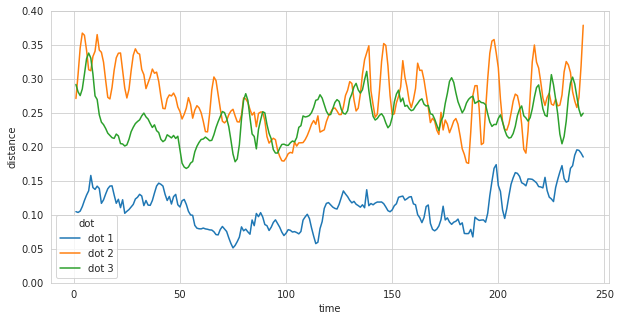

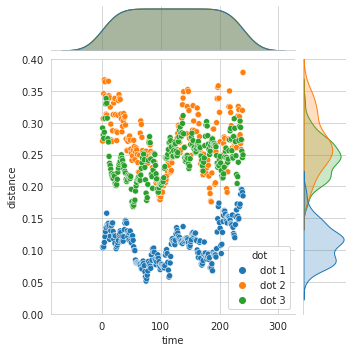

In [29]:
df_d = pd.DataFrame(dist, columns=['dot 1', 'dot 2', 'dot 3'])
df_d['time'] = np.arange(dist.shape[0]) + 1
df_d = df_d.melt(id_vars='time', var_name='dot', value_name='distance')

sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig_ = sns.lineplot(data=df_d, x='time', y='distance', hue='dot')
ax.set_ylim(0, 0.4)
fn = utils.ms.path_fig / 'three_dot_traj_distance1.pdf'
plt.savefig(fn, dpi=300)

# Joint plot
fig_ = sns.jointplot(data=df_d, x='time', y='distance', hue='dot', kind='scatter', height=5, ylim=(0, 0.4))
fn = utils.ms.path_fig / 'three_dot_traj_distance1_joint.pdf'
fig_.savefig(fn, dpi=300)

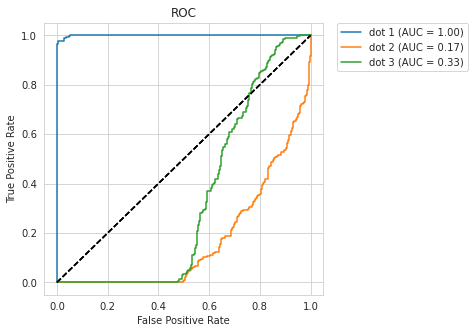

In [38]:
auc = []
fpr = dict()
tpr = dict()
auc = dict()
for i in range(dist.shape[1]):
    y_true = np.zeros(dist.shape)
    y_true[:, i] = 1
    fpr[i], tpr[i], thresholds = metrics.roc_curve(y_true.flatten(), -dist.flatten())
    auc[i] = metrics.auc(fpr[i], tpr[i])
    
# plot ROC
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(dist.shape[1]):
    ax.plot(fpr[i], tpr[i], label=f'dot {i+1} (AUC = {auc[i]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC')
    # set legend outside
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# save figure
fn = utils.ms.path_fig / 'three_dot_traj_distance1_ROC.pdf'
plt.savefig(fn, dpi=300)
    

In [34]:
# ---------------------------------------------------------------------------- #
#                                   dynamics                                   #
# ---------------------------------------------------------------------------- #
h_diff = np.diff(h, axis=0)
dist = []
for iDot in range(3):
    h1 = h_diff
    h2 = np.diff(h_disp[iDot], axis=0)
    
    dist_ = paired_distances(h1, h2, metric=dist_measure)
    dist.append(dist_)
    
dist = np.vstack(dist).T

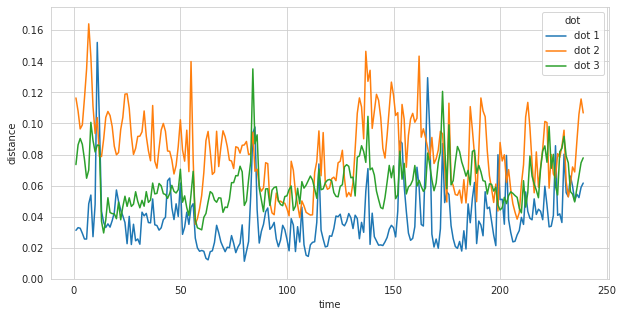

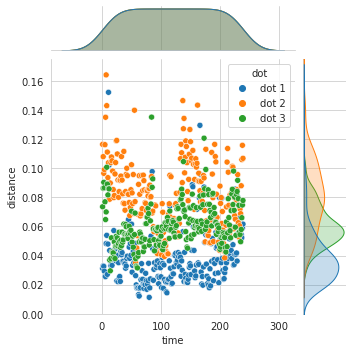

In [35]:
df_d = pd.DataFrame(dist, columns=['dot 1', 'dot 2', 'dot 3'])
df_d['time'] = np.arange(dist.shape[0]) + 1
df_d = df_d.melt(id_vars='time', var_name='dot', value_name='distance')

ylim = 0.175
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig_ = sns.lineplot(data=df_d, x='time', y='distance', hue='dot')
ax.set_ylim(0, ylim)
fn = utils.ms.path_fig / 'three_dot_traj_distance1_v.pdf'
plt.savefig(fn, dpi=300)

# Joint plot
fig_ = sns.jointplot(data=df_d, x='time', y='distance', hue='dot', kind='scatter', height=5, ylim=(0, ylim))
fn = utils.ms.path_fig / 'three_dot_traj_distance1_v_joint.pdf'
fig_.savefig(fn, dpi=300)

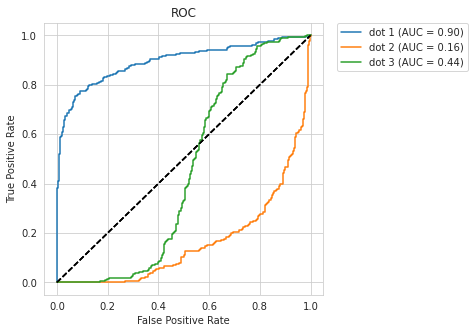

In [36]:
auc = []
fpr = dict()
tpr = dict()
auc = dict()
for i in range(dist.shape[1]):
    y_true = np.zeros(dist.shape)
    y_true[:, i] = 1
    fpr[i], tpr[i], thresholds = metrics.roc_curve(y_true.flatten(), -dist.flatten())
    auc[i] = metrics.auc(fpr[i], tpr[i])
    

# plot ROC
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(dist.shape[1]):
    ax.plot(fpr[i], tpr[i], label=f'dot {i+1} (AUC = {auc[i]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC')
    # set legend outside
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# save figure
fn = utils.ms.path_fig / 'three_dot_traj_distance1_v_ROC.pdf'
plt.savefig(fn, dpi=300)
    